In [1]:
# Developed by Samuel Horovatin at the University of Saskatchewan
# July, 2021
from plantcv import plantcv as pcv
import matplotlib.pyplot as plt
import os
import os.path
import shutil
import pandas as pd
import numpy as np

from skimage.transform import resize
from skimage.io import imread
from skimage.io import imshow
from sklearn.cluster import KMeans

In [2]:
plt.rcParams["figure.figsize"] = [8, 8]
class options:
    def __init__(self):
        # Input image path/filename
        self.datastore_base_dir = "/datastore/AGILE/BELToutput/LDP_Sebastian"
        self.extention_pattern = ".jpg"

        # Debug mode = None, "plot", or "print"
        self.debug = None
        # Store output images (True/False)
        self.writeimg = False
        # Results path/filename
        self.result = "results.txt"
        # Image output directory path
        self.outdir = "/datastore/BinfoLab/horovatin/Lentil/Grayscale/"
        # self.outdir = "/datastore/BinfoLab/horovatin/Lentil/Processed/"
        # self.groupdir ="/datastore/BinfoLab/horovatin/Lentil/Grouped/"

# Initialize options
args = options()
# Set PlantCV debug mode to input debug method
pcv.params.debug = args.debug
# Increase text size in plots
pcv.params.text_size = 20
pcv.params.text_thickness = 10

In [3]:
# Searches for all files with certain pattern in datastore_base_dir

files = []
for dirpath, dirnames, filenames in os.walk(args.datastore_base_dir):
    for filename in [f for f in filenames if f.endswith(args.extention_pattern)]:
        files.append(os.path.join(dirpath, filename))

print(f"=== Found ({len(files)}) files of pattern {args.extention_pattern} ===")

=== Found (624398) files of pattern .jpg ===


In [ ]:
# for lentil_image in os.listdir(args.test_dir):
#     if lentil_image[len(lentil_image)-3:] != 'png':
#         continue
#     img, path, filename = pcv.readimage(filename=args.test_dir+lentil_image)
#     img = pcv.white_balance(img) #Good to normalize the 
#     cs_plot = pcv.visualize.colorspaces(rgb_img=img, original_img=False)
#     s = pcv.rgb2gray_hsv(rgb_img=img, channel='s')
#     s_thresh = pcv.threshold.binary(gray_img=s, threshold=60, max_value=255, object_type='light') # threshold is 60 to remove little lentil flecks
#     b = pcv.rgb2gray_lab(rgb_img=img, channel='b')
#     b_thresh = pcv.threshold.binary(gray_img=b, threshold=137, max_value=255, object_type='light')
#     a = pcv.rgb2gray_lab(rgb_img=img, channel='a')
#     a_thresh = pcv.threshold.binary(gray_img=a, threshold=133, max_value=255, object_type='light')
#     bs = pcv.logical_or(bin_img1=s_thresh, bin_img2=b_thresh)
#     bsa = pcv.logical_or(bin_img1=bs, bin_img2=a_thresh)
#     bsa_fill1 = pcv.fill(bin_img=bsa, size=200) # Fill small noise
#     bsa_fill2 = pcv.dilate(gray_img=bsa_fill1, ksize=6, i=2)
#     # bsa_fill3 and bsa_fill4 are to get rid of tiny lentil flakes
#     bsa_fill3 = pcv.erode(bsa_fill2, ksize=12, i=6)
#     bsa_fill4 = pcv.dilate(gray_img=bsa_fill3, ksize=20, i=6) # If no lentil is present, can cause errors
#     # Coppied this check from "fill_holes" source: catches empty images caused by erode and dilate.
#     if len(np.shape(bsa_fill4)) != 2 or len(np.unique(bsa_fill4)) != 2:
#         continue
#     filled_mask1 = pcv.fill_holes(bsa_fill4)

#     id_objects, obj_hierarchy = pcv.find_objects(img=img, mask=filled_mask1)
#     roi_contour, roi_hierarchy = pcv.roi.rectangle(img, 0, 0, -400, -400)
#     roi_objects, roi_obj_hierarchy, kept_mask, obj_area = pcv.roi_objects(img, 'partial', roi_contour, roi_hierarchy, id_objects, obj_hierarchy)
#     clusters_i, contours, hierarchies = pcv.cluster_contours(img1, roi_objects, roi_obj_hierarchy, 4, 6)
#     # obj, mask = pcv.object_composition(img=img, contours=id_objects, hierarchy=obj_hierarchy)
#     # crop_img = pcv.auto_crop(img=img, obj=obj, padding_x=0, padding_y=0)
#     # pcv.print_image(crop_img, args.outdir+"cropped_"+lentil_image)

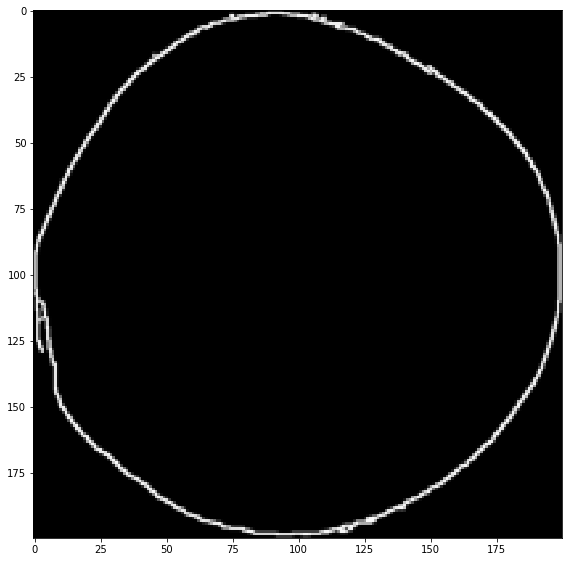

In [22]:
# Normalizes white balance and converts images to grayscale
# 
i=0
lentil_images=[]
lentil_images_names=[]

for lentil_img_path in files[1:10]:
    img, lentil_img_path, filename = pcv.readimage(filename=lentil_img_path)
    
    wbalance_img = pcv.white_balance(img) #Good to normalize the white balance
    gray_img = pcv.rgb2gray(wbalance_img)
    edges = pcv.canny_edge_detect(gray_img, thickness=3, sigma=1)
    img_resized=resize(edges,(200,200,3))
    
    imshow(img_resized)
    lentil_images.append(img_resized.flatten())
    lentil_images_names.append(filename)
    

In [ ]:
# Loads Data
lentil_images=[]
lentil_images_names=[]

for img in os.listdir(args.outdir): 
    img_array=imread(os.path.join(args.outdir,img))
    img_resized=resize(img_array,(200,200,3))  
    lentil_images.append(img_resized.flatten())
    lentil_images_names.append(img)

In [ ]:
kMax = min(10, len(lentil_images))
kMin = 1
lentil_models = []

# Fits KMean to data using multiple values for K
for k in range(kMin, kMax):
    print(f"========= Training k={k}... =========")
    model = KMeans(n_clusters=k, random_state=0).fit(lentil_images)
    lentil_models.append(model)


print(f"========= Training Complete! Models Trained = {kMax-kMin}... =========")    

In [ ]:
k = kMin
prediction_df = pd.DataFrame(columns=['img', 'k', 'group_pred']) 

for model in lentil_models:
    model_pred = model.predict(lentil_images)
    for name, pred in zip(lentil_images_names, model_pred):
        prediction_df = prediction_df.append({'img': name, 'k': k, 'group_pred': pred }, ignore_index=True)
    k = k + 1

prediction_df.to_csv("pattern.csv", encoding='utf-8', sep=',', index=False)
prediction_df

In [ ]:
# Sorts Images into folders based on K value and group

for k in range(kMin, kMax):
    # Creates k grouping folders.
    k_folder = os.path.join(args.groupdir, f"K{k}")
    os.mkdir(k_folder)
    for g in range(kMin-1, k+1):
        k_group_folder = os.path.join(k_folder, f"G{g}")
        os.mkdir(k_group_folder)
        for img in prediction_df[(prediction_df['group_pred'] == g) &(prediction_df['k'] == k)]['img']:
            try:
                shutil.copyfile(os.path.join(args.outdir, img), os.path.join(k_group_folder, img))
            # If source and destination are same
            except shutil.SameFileError:
                print("Source and destination represents the same file.")
            
            # If destination is a directory.
            except IsADirectoryError:
                print("Destination is a directory.")
            
            # If there is any permission issue
            except PermissionError:
                print("Permission denied.")
            
            # For other errors
            except:
                print("Error occurred while copying file.")